In [2]:
import os
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Input, Activation, Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
import numpy as np
import time
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [3]:


# 分類するクラス
classes = ["Aerial","Airplane","Balloon","couple","Earth","Girl","Lenna","Mandrill","milkdrop","Parrots","Pepper","Sailboat"]
nb_classes = len(classes)
#画像の大きさを設定
img_width, img_height = 150, 150

# トレーニング用とバリデーション用の画像格納先（パスは自分で設定してください）
train_data_dir = '/home/nakataniken/変形画像集/train'
validation_data_dir = '/home/nakataniken/変形画像集/test'

#トレーニングデータ用の画像数
nb_train_samples = 10201
#バリデーション用の画像数
nb_validation_samples = 1212
#バッチサイズ
batch_size = 100
#エポック数
nb_epoch = 20

In [4]:
# トレーンング用、バリデーション用データを生成するジェネレータ作成
train_datagen = ImageDataGenerator(
  rescale=1.0 / 255,
  #すでに画像の水増し済みの方は、下記２行は必要ありません。
  #zoom_range=0.2,
  #horizontal_flip=True
)

validation_datagen = ImageDataGenerator(rescale=1.0 / 255)

In [5]:
train_generator = train_datagen.flow_from_directory(
  train_data_dir,
  target_size=(img_width, img_height),
  color_mode='rgb',
  classes=classes,
  class_mode='categorical',
  batch_size=batch_size,
  shuffle=True)

validation_generator = validation_datagen.flow_from_directory(
  validation_data_dir,
  target_size=(img_width, img_height),
  color_mode='rgb',
  classes=classes,
  class_mode='categorical',
  batch_size=batch_size,
  shuffle=True)

Found 10189 images belonging to 12 classes.
Found 1200 images belonging to 12 classes.


In [6]:
# VGG16のロード。FC層は不要なので include_top=False
input_tensor = Input(shape=(img_width, img_height, 3))
vgg16 = VGG16(include_top=False, weights='imagenet', input_tensor=input_tensor)

# VGG16の図の緑色の部分（FC層）の作成
top_model = Sequential()
top_model.add(Flatten(input_shape=vgg16.output_shape[1:]))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(nb_classes, activation='softmax'))

# VGG16とFC層を結合してモデルを作成（完成図が上の図）
vgg_model = Model(input=vgg16.input, output=top_model(vgg16.output))

# VGG16の図の青色の部分は重みを固定（frozen）
for layer in vgg_model.layers[:15]:
    layer.trainable = False

# 多クラス分類を指定
vgg_model.compile(loss='categorical_crossentropy',
          optimizer=optimizers.SGD(lr=1e-3, momentum=0.9),
          metrics=['accuracy'])







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



/home/nakataniken/anaconda3/envs/keras_python3-7/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("se...)`
  del sys.path[0]


In [7]:
# Fine-tuning
history = vgg_model.fit_generator(
    train_generator,
    samples_per_epoch=nb_train_samples,
    nb_epoch=nb_epoch,
    validation_data=validation_generator,
    nb_val_samples=nb_validation_samples)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/home/nakataniken/anaconda3/envs/keras_python3-7/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  import sys
/home/nakataniken/anaconda3/envs/keras_python3-7/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=<keras_pre..., steps_per_epoch=102, epochs=20, validation_steps=1212)`
  import sys


Epoch 1/20
102/102 [==============================] - 128s 1s/step - loss: 1.2020 - acc: 0.6120 - val_loss: 0.0877 - val_acc: 0.9792
Epoch 2/20
102/102 [==============================] - 122s 1s/step - loss: 0.0989 - acc: 0.9713 - val_loss: 0.0254 - val_acc: 0.9950
Epoch 3/20
102/102 [==============================] - 122s 1s/step - loss: 0.0454 - acc: 0.9879 - val_loss: 0.0166 - val_acc: 0.9967
Epoch 4/20
102/102 [==============================] - 123s 1s/step - loss: 0.0244 - acc: 0.9938 - val_loss: 0.0107 - val_acc: 0.9975
Epoch 5/20
102/102 [==============================] - 126s 1s/step - loss: 0.0162 - acc: 0.9952 - val_loss: 0.0082 - val_acc: 0.9975
Epoch 6/20
102/102 [==============================] - 129s 1s/step - loss: 0.0141 - acc: 0.9967 - val_loss: 0.0056 - val_acc: 0.9992
Epoch 7/20
102/102 [==============================] - 130s 1s/step - loss: 0.0097 - acc: 0.9974 - val_loss: 0.0049 - val_acc: 0.9992
Epoch 8/20
102/102 [==============================] - 129s 1s/step - 

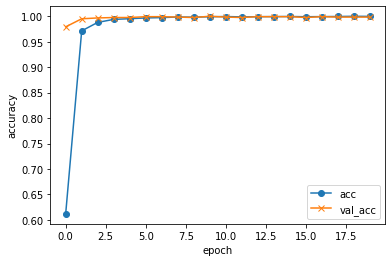

In [9]:
# 学習結果を描写
import matplotlib.pyplot as plt

#acc, val_accのプロット
plt.plot(history.history["acc"], label="acc", ls="-", marker="o")
plt.plot(history.history["val_acc"], label="val_acc", ls="-", marker="x")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(loc="best")
#Final.pngという名前で、結果を保存
plt.savefig('Final.png')
plt.show()